In [8]:
import numpy as np
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# データベースの接続情報
connection_config = {
    'user': 'shin',
    'password': 'shin_password',
    'port': '5432',
    'database': 'mobaku_base',
    'host': '10.33.230.198'
}

# データベース接続
connection = psycopg2.connect(**connection_config)
engine = create_engine(f"postgresql+psycopg2://{connection_config['user']}:{connection_config['password']}@{connection_config['host']}:{connection_config['port']}/{connection_config['database']}")

# メッシュIDリスト
mesh_list = [
    '513375753', '513375754', '513375763',
    '513375751', '513375752', '513375761',
    '513375653', '513375654', '513375663'
]

# 時間範囲
train_start_date = '2018-06-01 01:00:00'
test_end_date = '2018-07-11 23:59:59'



# SQLクエリでデータ取得
sql_query = f"""
SELECT datetime, mesh_id, population
FROM population_00000
WHERE mesh_id IN ({','.join(f"'{m}'" for m in mesh_list)})
AND datetime BETWEEN '{train_start_date}' AND '{test_end_date}'
ORDER BY datetime, mesh_id;
"""

# データ取得
df_pop = pd.read_sql(sql=sql_query, con=engine)
print(df_pop)
# datetime列を変換し、インデックスを設定
df_pop['datetime'] = pd.to_datetime(df_pop['datetime'])

# メッシュごとにデータをリスト化
mesh_population = {}
for mesh_id in mesh_list:
        # print(mesh_id)
        mesh_population[str(mesh_id)] = df_pop[df_pop['mesh_id'] == int(mesh_id)].set_index('datetime')['population'].tolist()

# DataFrameに変換
timestamps = pd.date_range(start=train_start_date, end=test_end_date, freq='h')
# mesh_population
df_ex = pd.DataFrame(mesh_population, index=timestamps)

# 結果の表示
print(df_ex.head())



                datetime    mesh_id  population
0    2018-06-01 01:00:00  513375653         149
1    2018-06-01 01:00:00  513375654         146
2    2018-06-01 01:00:00  513375663         290
3    2018-06-01 01:00:00  513375751          74
4    2018-06-01 01:00:00  513375752         118
...                  ...        ...         ...
8648 2018-07-11 23:00:00  513375752          47
8649 2018-07-11 23:00:00  513375753          46
8650 2018-07-11 23:00:00  513375754          44
8651 2018-07-11 23:00:00  513375761          28
8652 2018-07-11 23:00:00  513375763          77

[8653 rows x 3 columns]


ValueError: Length of values (951) does not match length of index (983)

DatetimeIndex(['2018-06-01 01:00:00', '2018-06-01 02:00:00',
               '2018-06-01 03:00:00', '2018-06-01 04:00:00',
               '2018-06-01 05:00:00', '2018-06-01 06:00:00',
               '2018-06-01 07:00:00', '2018-06-01 08:00:00',
               '2018-06-01 09:00:00', '2018-06-01 10:00:00',
               ...
               '2018-07-05 14:00:00', '2018-07-05 15:00:00',
               '2018-07-05 16:00:00', '2018-07-05 17:00:00',
               '2018-07-05 18:00:00', '2018-07-05 19:00:00',
               '2018-07-05 20:00:00', '2018-07-05 21:00:00',
               '2018-07-05 22:00:00', '2018-07-05 23:00:00'],
              dtype='datetime64[ns]', length=839, freq='h')


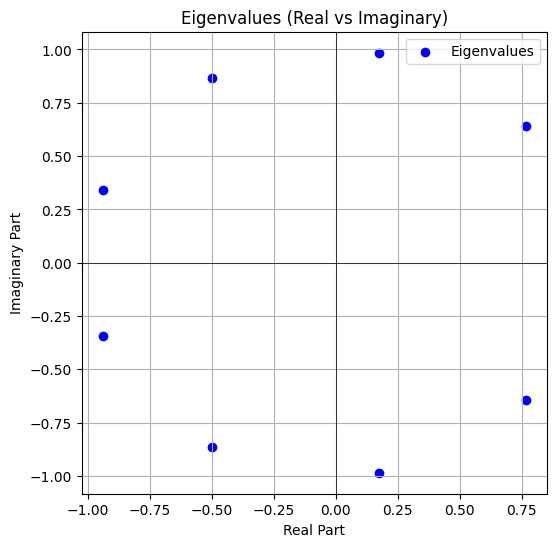

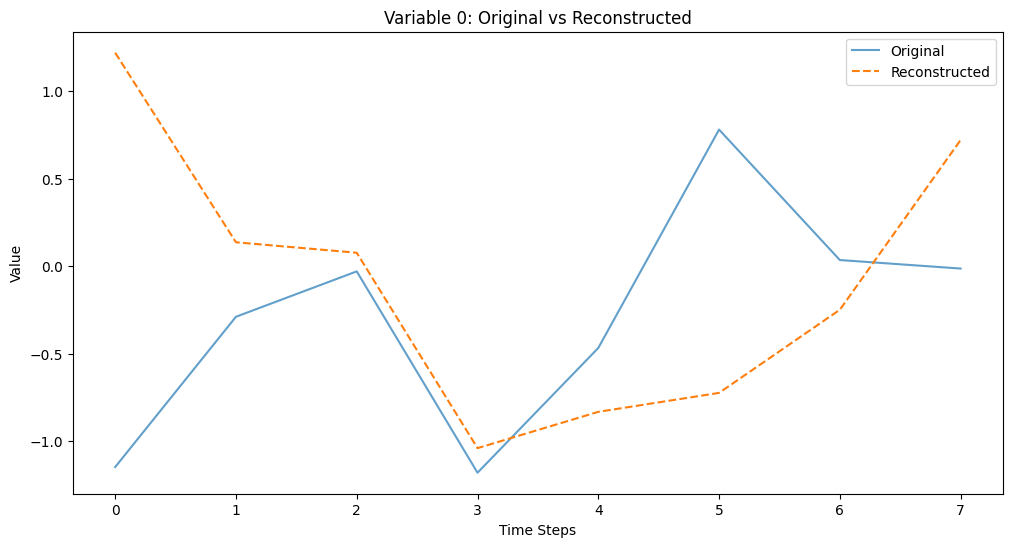

Short-term Modes: [4, 5, 6, 7]
Long-term Modes: [0, 1, 2, 3]


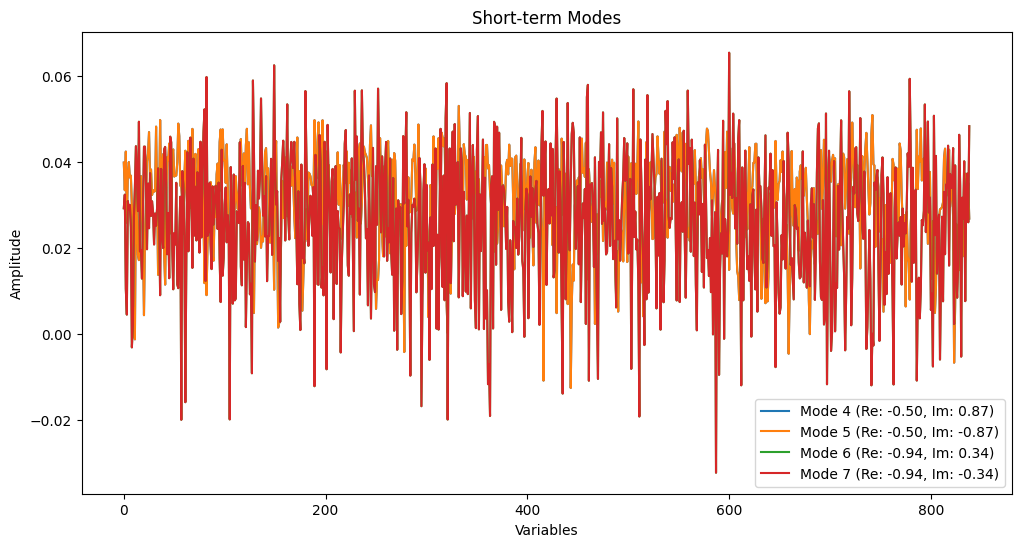

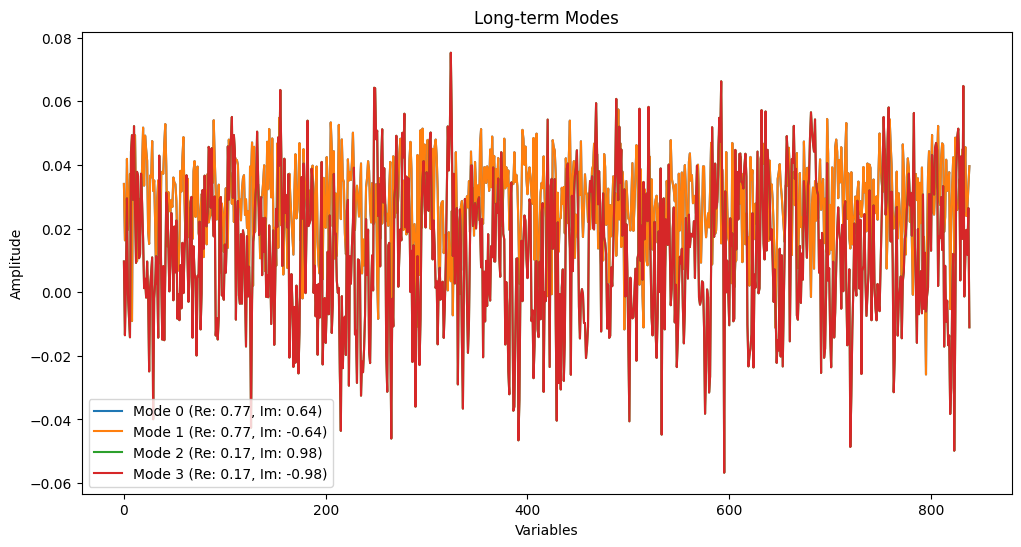

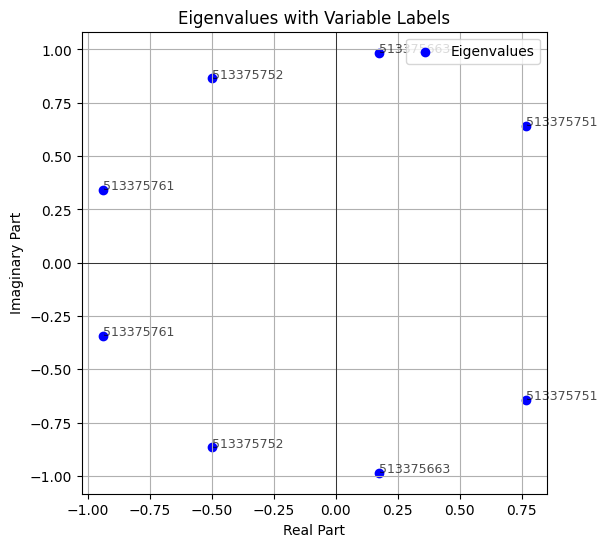

In [5]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# データフレームの読み込み (仮定: df_ex が与えられている)
# df_ex は行に変数、列に時系列データを持つ形式
# 必要に応じて変数名を確認
print(df_ex.index)

# インデックスを英語表記に変更
df_ex.index = df_ex.index.strftime("%Y-%m-%d %H:%M:%S")

# 日本語の列名を英語に置き換える関数
def rename_columns_to_english(df, column_mapping):
    """
    データフレームの列名を日本語から英語に置き換える。

    Parameters:
    df (pd.DataFrame): 対象のデータフレーム。
    column_mapping (dict): 日本語列名をキー、対応する英語名を値とした辞書。

    Returns:
    pd.DataFrame: 列名が変更されたデータフレーム。
    """
    new_columns = [column_mapping.get(col, col) for col in df.columns]
    df.columns = new_columns
    return df

# 例: 日本語列名と英語列名の対応辞書
column_mapping = {
    "雷注意報": "Thunderstorm Warning",
    "大雨注意報": "Heavy Rain Advisory",
    "洪水注意報": "Flood Advisory",
    "強風注意報": "Strong Wind Advisory",
    "大雨警報": "Heavy Rain Warning",
    "洪水警報": "Flood Warning",
    "暴風警報": "Storm Warning",
    "大雨特別警報": "Heavy Rain Emergency Warning",
    "waterLevel": "Water Level",
}

df_ex = rename_columns_to_english(df_ex, column_mapping)

# DMD解析用のデータ準備
def prepare_dmd_data(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T)  # 時系列方向を正規化
    return scaled_data.T

data = prepare_dmd_data(df_ex)

# データ行列の準備
X = data[:, :-1]  # 時刻 t のデータ
Y = data[:, 1:]   # 時刻 t+1 のデータ

# SVD 分解
U, Sigma, Vh = svd(X, full_matrices=False)

# ランク削減
rank = min(16, len(Sigma))  # 最大ランクを 16 に制限
U_r = U[:, :rank]
Sigma_r = np.diag(Sigma[:rank])
Vh_r = Vh[:rank, :]

# A_tilde の計算
A_tilde = U_r.T @ Y @ Vh_r.T @ np.linalg.inv(Sigma_r)

# 固有値・固有ベクトルの計算
eigvals, eigvecs = np.linalg.eig(A_tilde)

# ダイナミクスモードの計算
modes = U_r @ eigvecs

# 結果の可視化
def plot_eigenvalues(eigvals):
    plt.figure(figsize=(6, 6))
    plt.scatter(eigvals.real, eigvals.imag, c="blue", label="Eigenvalues")
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.title("Eigenvalues (Real vs Imaginary)")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid()
    plt.legend()
    plt.show()

# 固有値プロット
plot_eigenvalues(eigvals)

# 時系列復元（オプション）
def reconstruct_time_series(modes, eigvals, X_initial, timesteps):
    time_dynamics = np.zeros((modes.shape[1], timesteps), dtype=complex)
    for i in range(modes.shape[1]):
        time_dynamics[i, :] = (eigvals[i] ** np.arange(timesteps)) * X_initial[i]
    
    reconstructed = np.real(modes @ time_dynamics)
    return reconstructed

# 初期状態を X の最初の列とする
initial_state = U_r.T @ X[:, 0]
reconstructed = reconstruct_time_series(modes, eigvals, initial_state, X.shape[1])

# 結果の可視化
def plot_original_vs_reconstructed(original, reconstructed, variable_index):
    plt.figure(figsize=(12, 6))
    plt.plot(original[variable_index, :], label="Original", alpha=0.7)
    plt.plot(reconstructed[variable_index, :], label="Reconstructed", linestyle="--")
    plt.title(f"Variable {variable_index}: Original vs Reconstructed")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# 例: 変数 0 をプロット
plot_original_vs_reconstructed(X, reconstructed, 0)

# 短期と長期のモードを分離
def separate_modes(eigvals, eigvecs, threshold=0.1):
    """
    短期モードと長期モードを分離する。

    Parameters:
    eigvals (np.ndarray): 固有値。
    eigvecs (np.ndarray): 固有ベクトル。
    threshold (float): 境界となる減衰率（実数部分の閾値）。

    Returns:
    dict: 短期モードと長期モードのインデックス。
    """
    short_term = []
    long_term = []
    for i, val in enumerate(eigvals):
        if val.real < -threshold:
            short_term.append(i)
        else:
            long_term.append(i)
    return {"short_term": short_term, "long_term": long_term}

modes_split = separate_modes(eigvals, eigvecs)
print("Short-term Modes:", modes_split["short_term"])
print("Long-term Modes:", modes_split["long_term"])

# 短期モードと長期モードを別々に可視化
def plot_modes(modes, eigvals, modes_indices, title):
    plt.figure(figsize=(12, 6))
    for idx in modes_indices:
        plt.plot(np.real(modes[:, idx]), label=f"Mode {idx} (Re: {eigvals[idx].real:.2f}, Im: {eigvals[idx].imag:.2f})")
    plt.title(title)
    plt.xlabel("Variables")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

plot_modes(modes, eigvals, modes_split["short_term"], "Short-term Modes")
plot_modes(modes, eigvals, modes_split["long_term"], "Long-term Modes")

# 各変数の寄与度を計算し、固有値プロットに反映
def calculate_variable_impact(modes, var_names, mesh_index):
    impact = np.abs(modes[mesh_index, :])  # Aメッシュの成分を抽出して絶対値を取る
    impact_normalized = impact / np.sum(impact)  # 寄与率を計算
    return np.array(list(impact_normalized))

def plot_eigenvalues_with_labels(eigvals, impacts, var_names):
    plt.figure(figsize=(6, 6))
    plt.scatter(eigvals.real, eigvals.imag, c="blue", label="Eigenvalues")
    for i, eig in enumerate(eigvals):
        main_var = var_names[np.argmax(impacts[:, i])]
        plt.annotate(main_var, (eig.real, eig.imag), fontsize=9, alpha=0.7)
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.title("Eigenvalues with Variable Labels")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid()
    plt.legend()
    plt.show()

# 変数名を取得し、影響度を計算
var_names = list(df_ex.columns)
impacts = np.array([calculate_variable_impact(modes, var_names, i) for i in range(len(var_names))])

# ラベル付き固有値プロット
plot_eigenvalues_with_labels(eigvals, impacts, var_names)


Index(['2018-06-01 01:00:00', '2018-06-01 02:00:00', '2018-06-01 03:00:00',
       '2018-06-01 04:00:00', '2018-06-01 05:00:00', '2018-06-01 06:00:00',
       '2018-06-01 07:00:00', '2018-06-01 08:00:00', '2018-06-01 09:00:00',
       '2018-06-01 10:00:00',
       ...
       '2018-07-05 14:00:00', '2018-07-05 15:00:00', '2018-07-05 16:00:00',
       '2018-07-05 17:00:00', '2018-07-05 18:00:00', '2018-07-05 19:00:00',
       '2018-07-05 20:00:00', '2018-07-05 21:00:00', '2018-07-05 22:00:00',
       '2018-07-05 23:00:00'],
      dtype='object', length=839)


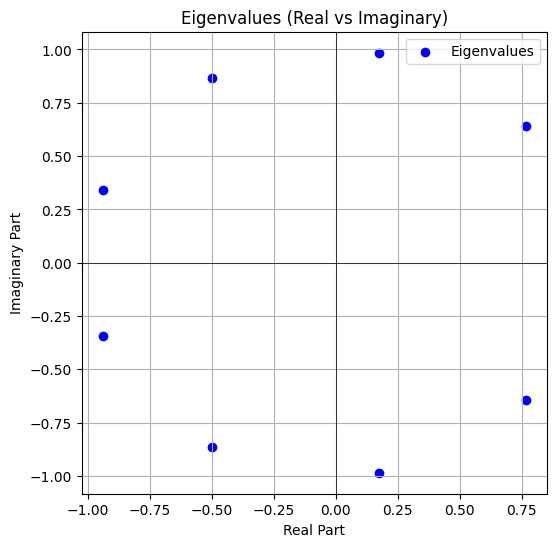

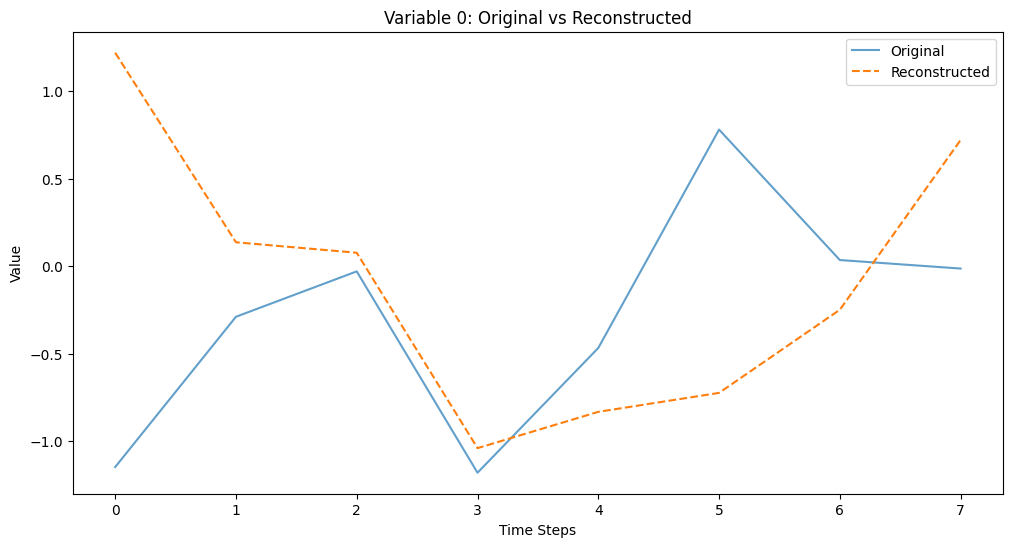

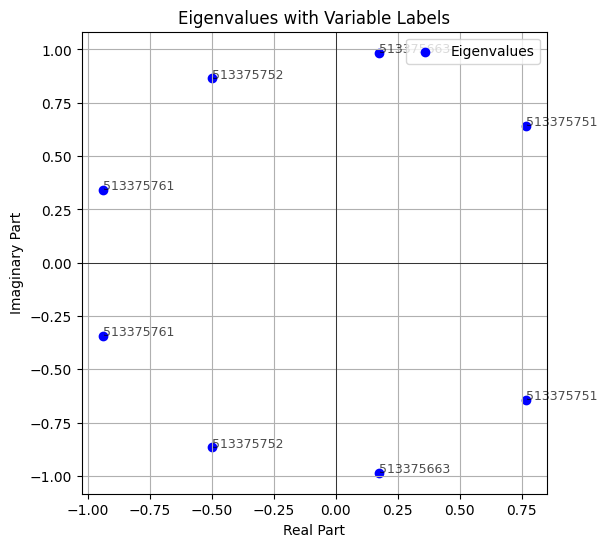

In [6]:
import numpy as np
import pandas as pd
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# データフレームの読み込み (仮定: df_ex が与えられている)
# df_ex は行に変数、列に時系列データを持つ形式
# 必要に応じて変数名を確認
print(df_ex.index)

# DMD解析用のデータ準備
def prepare_dmd_data(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T)  # 時系列方向を正規化
    return scaled_data.T

data = prepare_dmd_data(df_ex)

# データ行列の準備
X = data[:, :-1]  # 時刻 t のデータ
Y = data[:, 1:]   # 時刻 t+1 のデータ

# SVD 分解
U, Sigma, Vh = svd(X, full_matrices=False)

# ランク削減
rank = min(20, len(Sigma))  # 最大ランクを 16 に制限
U_r = U[:, :rank]
Sigma_r = np.diag(Sigma[:rank])
Vh_r = Vh[:rank, :]

# A_tilde の計算
A_tilde = U_r.T @ Y @ Vh_r.T @ np.linalg.inv(Sigma_r)

# 固有値・固有ベクトルの計算
eigvals, eigvecs = np.linalg.eig(A_tilde)

# ダイナミクスモードの計算
modes = U_r @ eigvecs

# 結果の可視化
def plot_eigenvalues(eigvals):
    plt.figure(figsize=(6, 6))
    plt.scatter(eigvals.real, eigvals.imag, c="blue", label="Eigenvalues")
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.title("Eigenvalues (Real vs Imaginary)")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid()
    plt.legend()
    plt.show()

# 固有値プロット
plot_eigenvalues(eigvals)

# 時系列復元（オプション）
def reconstruct_time_series(modes, eigvals, X_initial, timesteps):
    time_dynamics = np.zeros((modes.shape[1], timesteps), dtype=complex)
    for i in range(modes.shape[1]):
        time_dynamics[i, :] = (eigvals[i] ** np.arange(timesteps)) * X_initial[i]
    
    reconstructed = np.real(modes @ time_dynamics)
    return reconstructed

# 初期状態を X の最初の列とする
initial_state = U_r.T @ X[:, 0]
reconstructed = reconstruct_time_series(modes, eigvals, initial_state, X.shape[1])

# 結果の可視化
def plot_original_vs_reconstructed(original, reconstructed, variable_index):
    plt.figure(figsize=(12, 6))
    plt.plot(original[variable_index, :], label="Original", alpha=0.7)
    plt.plot(reconstructed[variable_index, :], label="Reconstructed", linestyle="--")
    plt.title(f"Variable {variable_index}: Original vs Reconstructed")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# 例: 変数 0 をプロット
plot_original_vs_reconstructed(X, reconstructed, 0)

# 各変数の寄与度を計算し、固有値プロットに反映
def calculate_variable_impact(modes, var_names, mesh_index):
    impact = np.abs(modes[mesh_index, :])  # Aメッシュの成分を抽出して絶対値を取る
    impact_normalized = impact / np.sum(impact)  # 寄与率を計算
    return np.array(list(impact_normalized))

def plot_eigenvalues_with_labels(eigvals, impacts, var_names):
    plt.figure(figsize=(6, 6))
    plt.scatter(eigvals.real, eigvals.imag, c="blue", label="Eigenvalues")
    for i, eig in enumerate(eigvals):
        main_var = var_names[np.argmax(impacts[:, i])]
        plt.annotate(main_var, (eig.real, eig.imag), fontsize=9, alpha=0.7)
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.title("Eigenvalues with Variable Labels")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid()
    plt.legend()
    plt.show()

# 変数名を取得し、影響度を計算
var_names = list(df_ex.columns)
impacts = np.array([calculate_variable_impact(modes, var_names, i) for i in range(len(var_names))])

# ラベル付き固有値プロット
plot_eigenvalues_with_labels(eigvals, impacts, var_names)
